- model : densenet161
- trans : transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
- optim : Adam(densenet161(pretrained=True).classifier.parameters(), lr = 0.001)
- lr_scheduler : StepLR(optim, step_size=7, gamma=0.1)

In [1]:
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import joblib
import time, copy

# Model
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary

# 성능 평가
from sklearn.metrics import f1_score

# 시각화
import matplotlib.pyplot as plt

In [2]:
import keras

Using TensorFlow backend.


In [6]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [7]:
train_set = torchvision.datasets.ImageFolder(root = './Train_faabad06fe/Train',
                                             transform = trans)
val_set = torchvision.datasets.ImageFolder(root = './Validation_9857834a3b',
                                           transform = trans)

In [8]:
print(train_set.classes)
print(val_set.classes)

['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']
['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']


In [9]:
image_set = {'train' : train_set, 'val' : val_set}
image_loaders = {x: DataLoader(image_set[x], batch_size=32, shuffle=True, num_workers=0)
                 for x in ['train', 'val']}
dataset_sizes = {x: len(image_set[x]) for x in ['train', 'val']}
class_names = image_set['train'].classes

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [11]:
device

device(type='cuda', index=0)

In [13]:
# 성능 시각화를 위한 losses, flscores 변수 선언.
losses = {'train':[], 'val':[]}
flscores = {'train':[], 'val':[]}

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1score = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)마다 train과 val 단계 진행.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정.
            else:
                model.eval()   # 모델을 평가 모드로 설정.

            running_loss = 0.0
            running_f1score = []

            # 데이터를 반복.
            for inputs, labels in image_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정.
                optimizer.zero_grad()
                
                # 학습.
                if phase == 'train':
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')

                        # 역전파 + 최적화 진행.
                        loss.requires_grad_(True)
                        loss.backward()
                        optimizer.step()
                
                # 평가.
                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')
                        
                # 통계.
                running_loss += loss.item() * inputs.size(0)
                running_f1score.append(f1score)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1score = sum(running_f1score) / len(running_f1score)
            
            losses[phase].append(epoch_loss)
            flscores[phase].append(epoch_f1score)
            
            print(f'{phase} Loss: {epoch_loss:.4f} F1-Score: {epoch_f1score:.4f}')

            # 모델 deep copy.
            if phase == 'val' and epoch_f1score > best_f1score:
                best_f1score = epoch_f1score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1-Score: {best_f1score:4f}')

    # 가장 나은 모델 가중치를 불러옴.
    model.load_state_dict(best_model_wts)
    return model

In [16]:
model_conv = torchvision.models.densenet161(pretrained=True)

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6025 Acc: 0.7963 F1-Score: 0.6496
val Loss: 0.3191 Acc: 0.9150 F1-Score: 0.8488

Epoch 1/14
----------
train Loss: 0.3051 Acc: 0.9060 F1-Score: 0.8327
val Loss: 0.2381 Acc: 0.9300 F1-Score: 0.8846

Epoch 2/14
----------
train Loss: 0.2474 Acc: 0.9196 F1-Score: 0.8522
val Loss: 0.1981 Acc: 0.9380 F1-Score: 0.8846

Epoch 3/14
----------
train Loss: 0.2209 Acc: 0.9239 F1-Score: 0.8673
val Loss: 0.1684 Acc: 0.9470 F1-Score: 0.9067

Epoch 4/14
----------
train Loss: 0.1901 Acc: 0.9379 F1-Score: 0.8894
val Loss: 0.1558 Acc: 0.9530 F1-Score: 0.9145

Epoch 5/14
----------
train Loss: 0.1769 Acc: 0.9425 F1-Score: 0.8973
val Loss: 0.1889 Acc: 0.9250 F1-Score: 0.8489

Epoch 6/14
----------
train Loss: 0.1579 Acc: 0.9536 F1-Score: 0.9111
val Loss: 0.1541 Acc: 0.9420 F1-Score: 0.8991

Epoch 7/14
----------
train Loss: 0.1492 Acc: 0.9561 F1-Score: 0.9152
val Loss: 0.1378 Acc: 0.9540 F1-Score: 0.9146

Epoch 8/14
----------
train Loss: 0.1420 Acc: 0.9583 F1-Score: 0.9229
val Loss: 0.1313

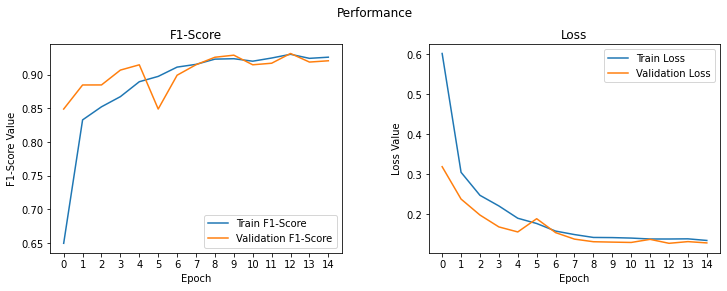

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 15 #에폭사이즈
ax1.plot(range(epochs), flscores['train'], label='Train F1-Score')
ax1.plot(range(epochs), flscores['val'], label='Validation F1-Score')
ax1.set_xticks(np.arange(0, epochs))
ax1.set_ylabel('F1-Score Value')
ax1.set_xlabel('Epoch')
ax1.set_title('F1-Score')
l1 = ax1.legend(loc="best")

ax2.plot(range(epochs), losses['train'], label='Train Loss')
ax2.plot(range(epochs), losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

f.savefig('DenseNetADAM', dpi = 300)

In [19]:
# 모델저장
torch.save(model_conv, 'DenseNetADAM.pt')